# 1.t-SNE

Load training/testing set graph data...
Extracting graph features...
Extracting GAT model features...
t-SNE Visualization...
  A: Train AAIndex ...
  B: Test AAIndex ...
  C: Train ESMC ...
  D: Test ESMC ...
  E: Test ESMC after 3-layer GAT ...
  F: Test ESMC Classifier Layer ...
t-SNE visualization saved to 7_Visualization_t-SNE_UMAP/t-SNE_3x2.png


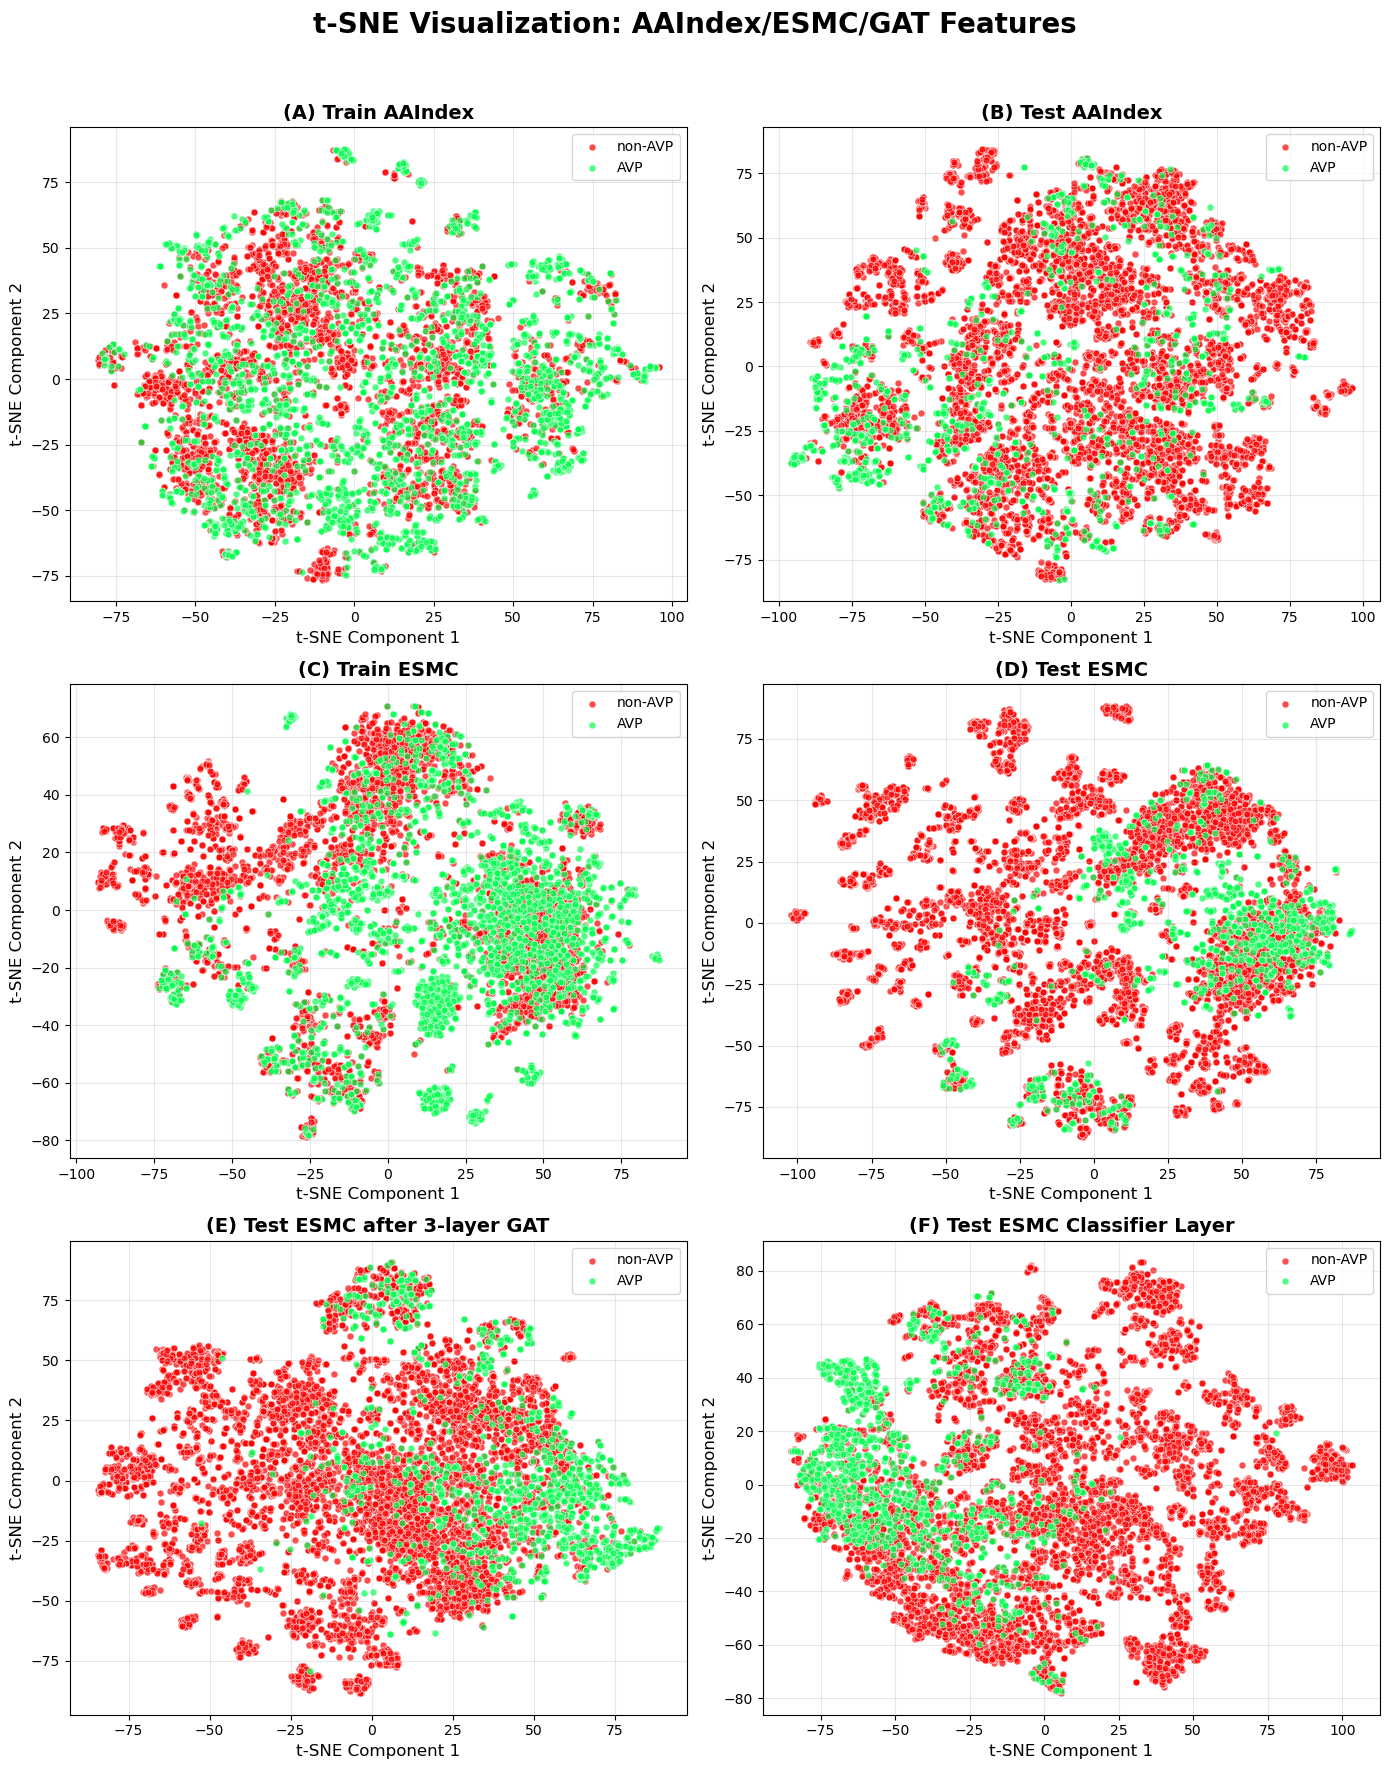

In [ ]:
# =========================
# t-SNE 3行2列特征分布可视化
# =========================

import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from pathlib import Path

from Feature_extraction.utils import load_dataset
from Model_training_and_testing.GAT import create_model
from torch_geometric.loader import DataLoader

# 配置路径
train_aaindex_path = "3_Graph_Data/TR/TR_AAIndex_4.0A.pkl"
train_esmc_path    = "3_Graph_Data/TR/TR_ESMC_4.0A.pkl"
test_aaindex_path  = "3_Graph_Data/TS/TS_AAIndex_4.0A.pkl"
test_esmc_path     = "3_Graph_Data/TS/TS_ESMC_4.0A.pkl"
model_dir          = "4_Results_TR_RS/GAT_Comparison_4.0A/3Layer_GAT"

# 颜色
colors = ['#FD0000', '#00FF4C']  # 0: 非AVP红，1: AVP绿
labels_text = ['non-AVP', 'AVP']

def compute_sequence_statistics(features):
    """对节点特征做均值、标准差、最小、最大拼接"""
    if features.ndim == 1:
        features = features.reshape(1, -1)
    stats = [np.mean(features, axis=0), np.std(features, axis=0),
             np.min(features, axis=0), np.max(features, axis=0)]
    return np.concatenate(stats)

def extract_graph_features(graphs):
    """提取每个图的统计特征和标签"""
    features, labels = [], []
    for g in graphs:
        node_feat = g.x.numpy() if hasattr(g.x, 'numpy') else g.x
        features.append(compute_sequence_statistics(node_feat))
        label = getattr(g, 'y', 0)
        if hasattr(label, 'item'):
            label = label.item()
        elif isinstance(label, np.ndarray):
            label = label.item() if label.size == 1 else label[0]
        labels.append(int(label))
    return np.array(features), np.array(labels)

def extract_gat_features(graphs, model_dir, device, layer_keys=('layer_3', 'classifier')):
    """提取GAT模型指定层的特征"""
    # 加载模型
    models_dir = Path(model_dir) / 'models'
    model_files = sorted(models_dir.glob("best_model_fold_*.pth"))
    assert model_files, f"No model found in {models_dir}"
    checkpoint = torch.load(model_files[0], map_location=device, weights_only=False)
    model = create_model(
        checkpoint['model_params']['node_feature_dim'],
        num_layers=checkpoint['num_layers'],
        **{k: v for k, v in checkpoint['model_params'].items() if k != 'node_feature_dim'}
    ).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # 提取特征
    loader = DataLoader(graphs, batch_size=64, shuffle=False)
    features_dict = {k: [] for k in layer_keys}
    labels = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            x = model.process_input(batch.x)
            layer_outputs = []
            for i in range(model.num_layers):
                x = model.gat_convs[i](x, batch.edge_index)
                x = model.gat_norms[i](x, batch.batch)
                x = torch.nn.functional.relu(x)
                layer_outputs.append(x.clone())
                if i < model.num_layers - 1:
                    x = torch.nn.functional.dropout(x, p=model.drop, training=model.training)
            graph_features = model.apply_pooling(x, batch.edge_index, batch.batch)
            classifier_hidden = graph_features
            for i, layer in enumerate(model.classifier):
                if i < len(model.classifier) - 1:
                    classifier_hidden = layer(classifier_hidden)
                    classifier_hidden = torch.nn.functional.relu(classifier_hidden)
                else:
                    classifier_final_features = classifier_hidden
                    break
            if len(model.classifier) == 1:
                classifier_final_features = graph_features
            # batch分割
            unique_batches = torch.unique(batch.batch)
            for batch_id in unique_batches:
                mask = batch.batch == batch_id
                # layer_3
                if 'layer_3' in layer_keys:
                    layer3_feat = layer_outputs[2][mask].cpu().numpy()
                    features_dict['layer_3'].append(compute_sequence_statistics(layer3_feat))
                # classifier
                if 'classifier' in layer_keys:
                    idx = (batch_id == unique_batches).nonzero(as_tuple=True)[0].item()
                    features_dict['classifier'].append(classifier_final_features[idx].cpu().numpy())
            # 标签
            for g in batch.to_data_list():
                label = getattr(g, 'y', 0)
                if hasattr(label, 'item'):
                    label = label.item()
                elif isinstance(label, np.ndarray):
                    label = label.item() if label.size == 1 else label[0]
                labels.append(int(label))
    for k in features_dict:
        features_dict[k] = np.array(features_dict[k])
    return features_dict, np.array(labels)

def tsne_transform(features, random_state=42):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    perplexity = min(30, (len(features_scaled) - 1) // 3)
    tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=1000, random_state=random_state, verbose=0)
    return tsne.fit_transform(features_scaled)

# 1. 加载数据
print("Load training/testing set graph data...")
train_aa_graphs = load_dataset(train_aaindex_path)
train_esmc_graphs = load_dataset(train_esmc_path)
test_aa_graphs = load_dataset(test_aaindex_path)
test_esmc_graphs = load_dataset(test_esmc_path)

# 2. 提取统计特征
print("Extracting graph features...")
train_aa_feat, train_aa_label = extract_graph_features(train_aa_graphs)
test_aa_feat,  test_aa_label  = extract_graph_features(test_aa_graphs)
train_esmc_feat, train_esmc_label = extract_graph_features(train_esmc_graphs)
test_esmc_feat,  test_esmc_label  = extract_graph_features(test_esmc_graphs)

# 3. 提取GAT模型特征（测试集ESMC）
print("Extracting GAT model features...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gat_features, gat_labels = extract_gat_features(test_esmc_graphs, model_dir, device, layer_keys=('layer_3', 'classifier'))

# 4. t-SNE降维
print("t-SNE Visualization...")
tsne_data = [
    (train_aa_feat, train_aa_label, "A", "Train AAIndex"),
    (test_aa_feat,  test_aa_label,  "B", "Test AAIndex"),
    (train_esmc_feat, train_esmc_label, "C", "Train ESMC"),
    (test_esmc_feat,  test_esmc_label,  "D", "Test ESMC"),
    (gat_features['layer_3'], gat_labels, "E", "Test ESMC after 3-layer GAT"),
    (gat_features['classifier'], gat_labels, "F", "Test ESMC Classifier Layer"),
]
tsne_results = []
for features, labels, tag, title in tsne_data:
    print(f"  {tag}: {title} ...")
    tsne_emb = tsne_transform(features)
    tsne_results.append((tsne_emb, labels, tag, title))

# 5. 绘图
save_dir = "6_Visualization_t-SNE_UMAP"
os.makedirs(save_dir, exist_ok=True)  # 自动创建目录

fig, axes = plt.subplots(3, 2, figsize=(14, 18))
fig.suptitle('t-SNE Visualization: AAIndex/ESMC/GAT Features', fontsize=20, fontweight='bold', y=0.98)
for idx, (tsne_emb, labels, tag, title) in enumerate(tsne_results):
    ax = axes[idx // 2, idx % 2]
    for i, label_name in enumerate(labels_text):
        mask = labels == i
        ax.scatter(tsne_emb[mask, 0], tsne_emb[mask, 1], c=colors[i], label=label_name, alpha=0.7, s=25, edgecolors='white', linewidth=0.5)
    ax.set_xlabel('t-SNE Component 1', fontsize=12)
    ax.set_ylabel('t-SNE Component 2', fontsize=12)
    ax.set_title(f'({tag}) {title}', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# 保存图片
save_path = os.path.join(save_dir, "t-SNE_3x2.png")
plt.savefig(save_path, dpi=600, bbox_inches='tight', facecolor='white')
print(f"t-SNE visualization saved to {save_path}")
plt.show()

# 2.UMAP

Load training/testing set graph data...
Extracting graph features...
Extracting GAT model features...
UMAP Visualization...
  A: Train AAIndex ...
  B: Test AAIndex ...
  C: Train ESMC ...
  D: Test ESMC ...
  E: Test ESMC after 3-layer GAT ...
  F: Test ESMC Classifier Layer ...
UMAPU visualization saved to 7_Visualization_t-SNE_UMAP/UMAP_3x2.png


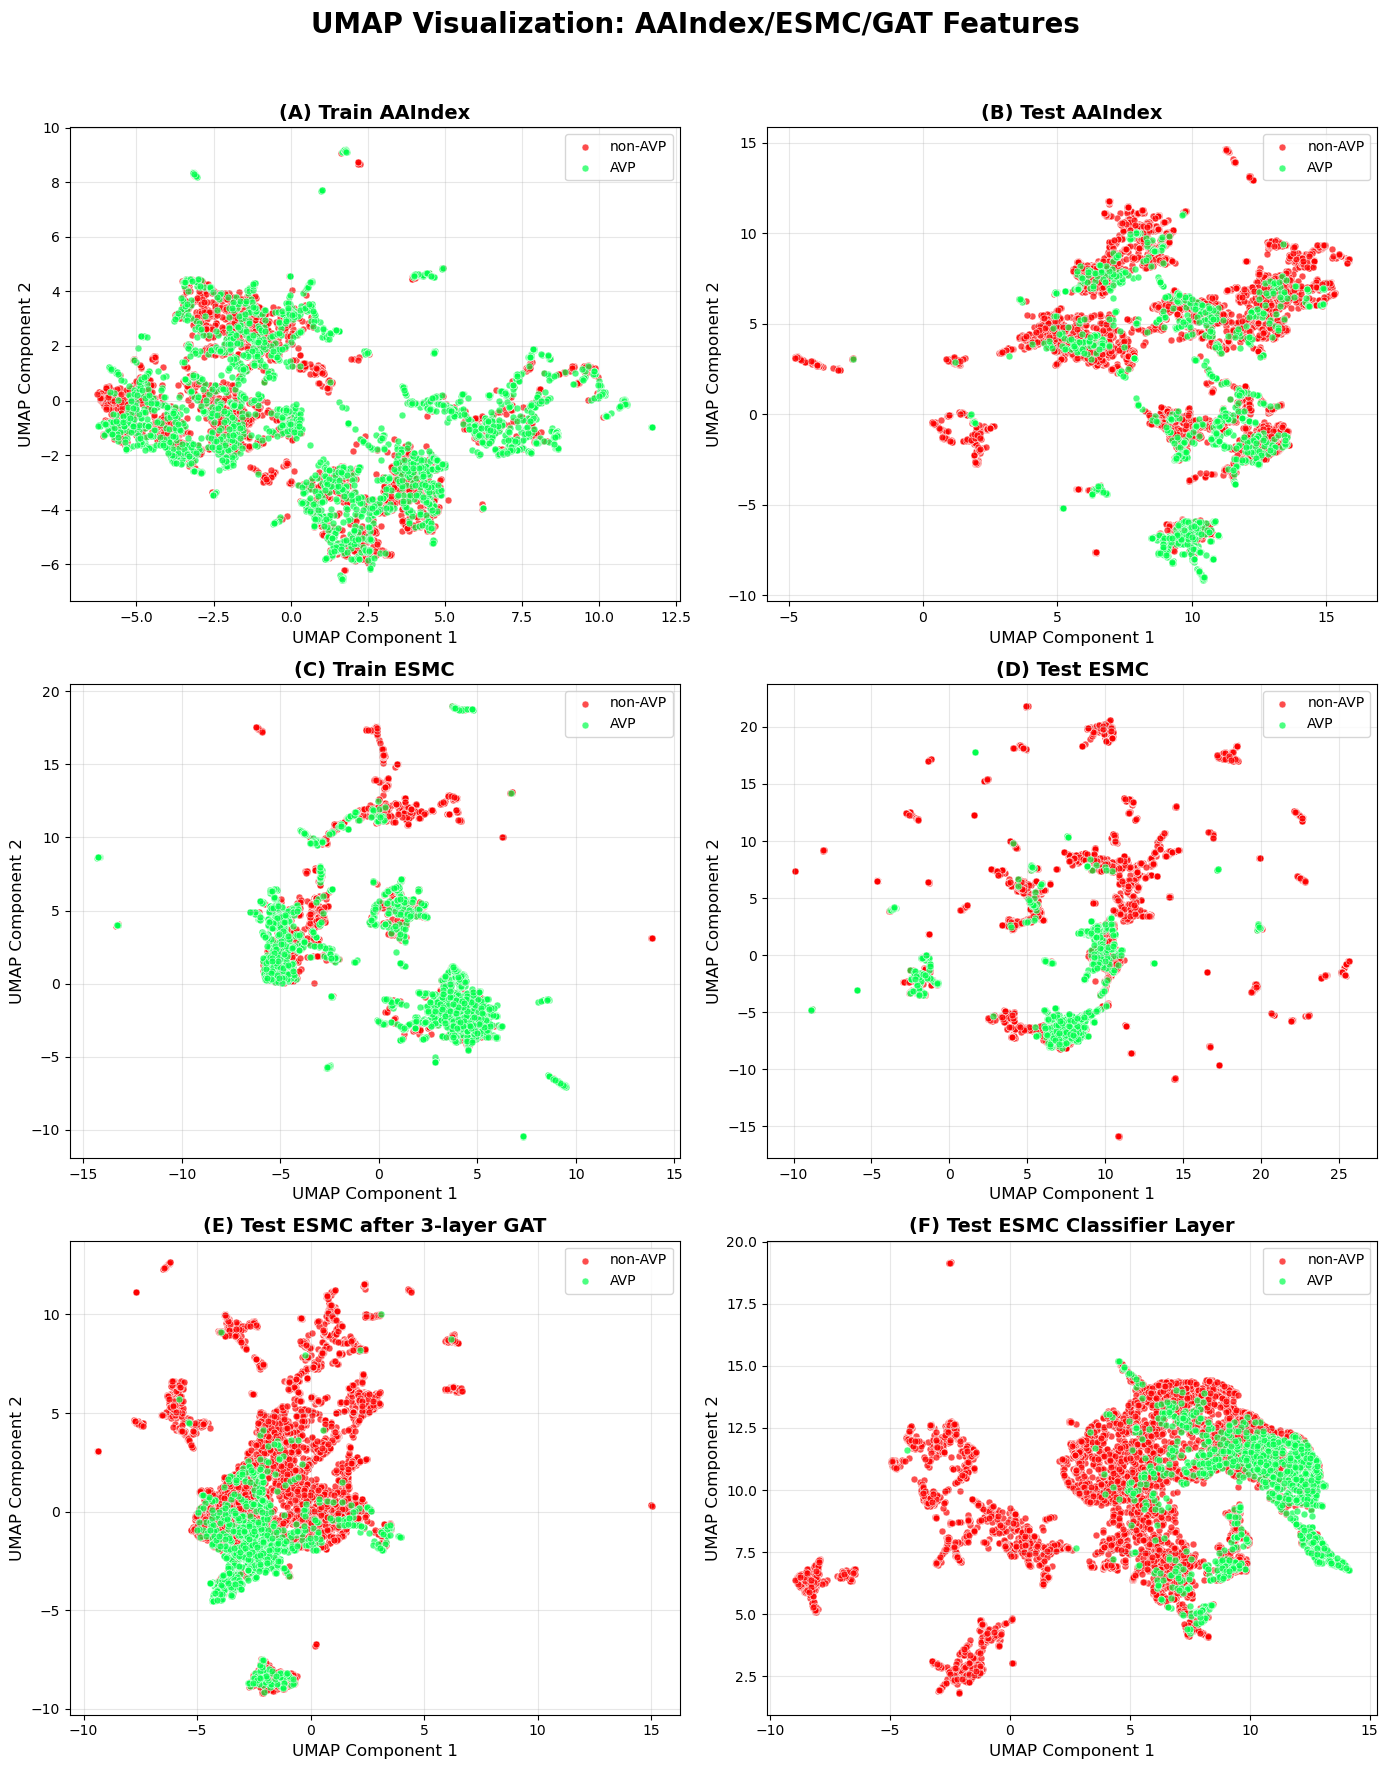

In [ ]:
# =========================
# UMAP 3行2列特征分布可视化
# =========================

import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import umap
import warnings
warnings.filterwarnings("ignore")

from Feature_extraction.utils import load_dataset
from Model_training_and_testing.GAT import create_model
from torch_geometric.loader import DataLoader

# 配置路径
train_aaindex_path = "3_Graph_Data/TR/TR_AAIndex_4.0A.pkl"
train_esmc_path    = "3_Graph_Data/TR/TR_ESMC_4.0A.pkl"
test_aaindex_path  = "3_Graph_Data/TS/TS_AAIndex_4.0A.pkl"
test_esmc_path     = "3_Graph_Data/TS/TS_ESMC_4.0A.pkl"
model_dir          = "4_Results_TR_RS/GAT_Comparison_4.0A/3Layer_GAT"

# 颜色
colors = ['#FD0000', '#00FF4C']  # 0: 非AVP红，1: AVP绿
labels_text = ['non-AVP', 'AVP']

def compute_sequence_statistics(features):
    """对节点特征做均值、标准差、最小、最大拼接"""
    if features.ndim == 1:
        features = features.reshape(1, -1)
    stats = [np.mean(features, axis=0), np.std(features, axis=0),
             np.min(features, axis=0), np.max(features, axis=0)]
    return np.concatenate(stats)

def extract_graph_features(graphs):
    """提取每个图的统计特征和标签"""
    features, labels = [], []
    for g in graphs:
        node_feat = g.x.numpy() if hasattr(g.x, 'numpy') else g.x
        features.append(compute_sequence_statistics(node_feat))
        label = getattr(g, 'y', 0)
        if hasattr(label, 'item'):
            label = label.item()
        elif isinstance(label, np.ndarray):
            label = label.item() if label.size == 1 else label[0]
        labels.append(int(label))
    return np.array(features), np.array(labels)

def extract_gat_features(graphs, model_dir, device, layer_keys=('layer_3', 'classifier')):
    """提取GAT模型指定层的特征"""
    models_dir = Path(model_dir) / 'models'
    model_files = sorted(models_dir.glob("best_model_fold_*.pth"))
    assert model_files, f"No model found in {models_dir}"
    checkpoint = torch.load(model_files[0], map_location=device, weights_only=False)
    model = create_model(
        checkpoint['model_params']['node_feature_dim'],
        num_layers=checkpoint['num_layers'],
        **{k: v for k, v in checkpoint['model_params'].items() if k != 'node_feature_dim'}
    ).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    loader = DataLoader(graphs, batch_size=64, shuffle=False)
    features_dict = {k: [] for k in layer_keys}
    labels = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            x = model.process_input(batch.x)
            layer_outputs = []
            for i in range(model.num_layers):
                x = model.gat_convs[i](x, batch.edge_index)
                x = model.gat_norms[i](x, batch.batch)
                x = torch.nn.functional.relu(x)
                layer_outputs.append(x.clone())
                if i < model.num_layers - 1:
                    x = torch.nn.functional.dropout(x, p=model.drop, training=model.training)
            graph_features = model.apply_pooling(x, batch.edge_index, batch.batch)
            classifier_hidden = graph_features
            for i, layer in enumerate(model.classifier):
                if i < len(model.classifier) - 1:
                    classifier_hidden = layer(classifier_hidden)
                    classifier_hidden = torch.nn.functional.relu(classifier_hidden)
                else:
                    classifier_final_features = classifier_hidden
                    break
            if len(model.classifier) == 1:
                classifier_final_features = graph_features
            unique_batches = torch.unique(batch.batch)
            for batch_id in unique_batches:
                mask = batch.batch == batch_id
                if 'layer_3' in layer_keys:
                    layer3_feat = layer_outputs[2][mask].cpu().numpy()
                    features_dict['layer_3'].append(compute_sequence_statistics(layer3_feat))
                if 'classifier' in layer_keys:
                    idx = (batch_id == unique_batches).nonzero(as_tuple=True)[0].item()
                    features_dict['classifier'].append(classifier_final_features[idx].cpu().numpy())
            for g in batch.to_data_list():
                label = getattr(g, 'y', 0)
                if hasattr(label, 'item'):
                    label = label.item()
                elif isinstance(label, np.ndarray):
                    label = label.item() if label.size == 1 else label[0]
                labels.append(int(label))
    for k in features_dict:
        features_dict[k] = np.array(features_dict[k])
    return features_dict, np.array(labels)

def umap_transform(features, random_state=42):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=random_state, verbose=False)
    return reducer.fit_transform(features_scaled)

# 1. 加载数据
print("Load training/testing set graph data...")
train_aa_graphs = load_dataset(train_aaindex_path)
train_esmc_graphs = load_dataset(train_esmc_path)
test_aa_graphs = load_dataset(test_aaindex_path)
test_esmc_graphs = load_dataset(test_esmc_path)

# 2. 提取统计特征
print("Extracting graph features...")
train_aa_feat, train_aa_label = extract_graph_features(train_aa_graphs)
test_aa_feat,  test_aa_label  = extract_graph_features(test_aa_graphs)
train_esmc_feat, train_esmc_label = extract_graph_features(train_esmc_graphs)
test_esmc_feat,  test_esmc_label  = extract_graph_features(test_esmc_graphs)

# 3. 提取GAT模型特征（测试集ESMC）
print("Extracting GAT model features...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gat_features, gat_labels = extract_gat_features(test_esmc_graphs, model_dir, device, layer_keys=('layer_3', 'classifier'))

# 4. UMAP降维
print("UMAP Visualization...")
umap_data = [
    (train_aa_feat, train_aa_label, "A", "Train AAIndex"),
    (test_aa_feat,  test_aa_label,  "B", "Test AAIndex"),
    (train_esmc_feat, train_esmc_label, "C", "Train ESMC"),
    (test_esmc_feat,  test_esmc_label,  "D", "Test ESMC"),
    (gat_features['layer_3'], gat_labels, "E", "Test ESMC after 3-layer GAT"),
    (gat_features['classifier'], gat_labels, "F", "Test ESMC Classifier Layer"),
]
umap_results = []
for features, labels, tag, title in umap_data:
    print(f"  {tag}: {title} ...")
    umap_emb = umap_transform(features)
    umap_results.append((umap_emb, labels, tag, title))

# 5. 绘图
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
fig.suptitle('UMAP Visualization: AAIndex/ESMC/GAT Features', fontsize=20, fontweight='bold', y=0.98)
for idx, (umap_emb, labels, tag, title) in enumerate(umap_results):
    ax = axes[idx // 2, idx % 2]
    for i, label_name in enumerate(labels_text):
        mask = labels == i
        ax.scatter(umap_emb[mask, 0], umap_emb[mask, 1], c=colors[i], label=label_name, alpha=0.7, s=25, edgecolors='white', linewidth=0.5)
    ax.set_xlabel('UMAP Component 1', fontsize=12)
    ax.set_ylabel('UMAP Component 2', fontsize=12)
    ax.set_title(f'({tag}) {title}', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# 保存图片
save_dir = "6_Visualization_t-SNE_UMAP"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "UMAP_3x2.png")
plt.savefig(save_path, dpi=600, bbox_inches='tight', facecolor='white')
print(f"UMAPU visualization saved to {save_path}")
plt.show()